# dev for Getting intersections of curves in numpy

In [2]:
#pylab
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pylab import imshow, show

import skimage as sk
from skimage import measure, filters

import matplotlib.pyplot as plt, numpy as np, os
from numba import njit, jit, vectorize
from PIL import Image
import imageio
# import cv2 as cv

#automate the boring stuff
from IPython import utils
import time, os, sys, re
beep = lambda x: os.system("echo -n '\\a';sleep 0.2;" * x)
if not 'nb_dir' in globals():
    nb_dir = os.getcwd()
width = 512
height = 512
channel_no = 3

#load the libraries
from lib.operari import *
from lib.ProgressBar import *
from lib.minimal_model import *
from lib.TexturePlot import *
from lib.get_tips import *
from lib.minimal_model import *
from lib.intersection import *
#TODO: use cuda via numba
from numba import jit, njit, vectorize, cuda, uint32, f8, uint8
# from lib.contours_to_tips import *

%autocall 1
%load_ext autoreload
%autoreload 2

Automatic calling is: Smart
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### runtime speedtest results

In [ ]:
a, b = 1, 2
phi = np.linspace(3, 10, 100)
x1 = a*phi - b*np.sin(phi)
y1 = a - b*np.cos(phi)

x2=phi
y2=np.sin(phi)+2
tips = intersection(x1,y1,x2,y2)
x,y = tips

plt.plot(x1,y1,c='r')
plt.plot(x2,y2,c='g')
plt.plot(x,y,'*k')
plt.show()

- without numba = 3.34 seconds

In [ ]:
%time
tips = intersection(x1,y1,x2,y2)

# define hidden helper functions

In [ ]:
def _rect_inter_inner(x1, x2):
    assert(type(x1)==np.ndarray)
    assert(type(x2)==np.ndarray)
    n1 = x1.shape[0]-1
    n2 = x2.shape[0]-1
    X1 = np.c_[x1[:-1], x1[1:]]
    X2 = np.c_[x2[:-1], x2[1:]]
    S1 = np.tile(X1.min(axis=1), (n2, 1)).T
    S2 = np.tile(X2.max(axis=1), (n1, 1))
    S3 = np.tile(X1.max(axis=1), (n2, 1)).T
    S4 = np.tile(X2.min(axis=1), (n1, 1))
    return S1, S2, S3, S4

def _rectangle_intersection_(x1, y1, x2, y2):
    S1, S2, S3, S4 = _rect_inter_inner(x1, x2)
    S5, S6, S7, S8 = _rect_inter_inner(y1, y2)

    C1 = np.less_equal(S1, S2)
    C2 = np.greater_equal(S3, S4)
    C3 = np.less_equal(S5, S6)
    C4 = np.greater_equal(S7, S8)

    ii, jj = np.nonzero(C1 & C2 & C3 & C4)
    return ii, jj

# create visualization for fast, parallelizeable, curve intersection
- written completely in numpy
- TODO: make input types work with numba.njit or numba.cuda.jit

In [ ]:
S1, S2, S3, S4 = _rect_inter_inner(x1, x2)
S5, S6, S7, S8 = _rect_inter_inner(y1, y2)

In [ ]:
fig, axs = plt.subplots(2,4)#,figsize=(8,4))
a = list(axs[0])
a.extend(list(axs[1]))
S_lst = (S1,S2,S3,S4,S5,S6,S7,S8)
for n,ax,S in list(zip(range(len(S_lst)), a, S_lst)):
#     print(ax)
    ax.imshow(S)
    ax.axis('off')
    ax.set_title(f'$S{n+1}$')
fig.savefig('Figures/fast_intersection_coordinates.svg')

In [ ]:
C1 = np.less_equal(S1, S2)
C2 = np.greater_equal(S3, S4)
C3 = np.less_equal(S5, S6)
C4 = np.greater_equal(S7, S8)

fig, axs = plt.subplots(1,4)#,figsize=(8,4))
# a = list(axs[0])
# a.extend(list(axs[1]))
a = axs
S_lst = (C1,C2,C3,C4)
for n,ax,S in list(zip(range(len(S_lst)), a, S_lst)):
#     print(ax)
    ax.imshow(S)
    ax.axis('off')
    ax.set_title(f'$C{n+1}$')
fig.savefig('Figures/fast_intersection_booleans.pdf')

In [ ]:
a, b = 1, 2
phi = np.linspace(3, 10, 100)
x1 = a*phi - b*np.sin(phi)
y1 = a - b*np.cos(phi)

x2=phi
y2=np.sin(phi)+2
tips = intersection(x1,y1,x2,y2)
x,y = tips
plt.figure(figsize=(4,4))
plt.plot(y1,x1,c='r')
plt.plot(y2,x2,c='g')
plt.plot(y,x,'*b')
plt.axis('off')
# plt.show()
plt.savefig('Figures/fast_intersection_example.svg')

# TODO(later): make/test rotate function for exception handling in intersect()
_application: retry funny intersection calls with a 45º rotation_<br>
if intersections(x) fails:
    return $R^{-1}\text{intersections}(X)R$ for rotation by pi/4 in out-of-plane axis<br>
`scipy.ndimage.rotate(input, angle, axes=(1, 0), reshape=True, output=None, order=3, mode='constant', cval=0.0, prefilter=True)`

# make intersection enforce pbc!!!
- DONE: Make a naive padded texture that enforces periodic boundary conditions
- DONE: get tips = intersection(padded_texture)
- DONE: map tips to original xy coordinates.  do they agree?
- TODO: remove duplicate tips
- TODO: ^put all that into a function and test it

In [3]:
#Make a naive padded texture that enforces periodic boundary conditions
txt = np.load(f'Data/buffer_chaos_circle6_sigma_5_threshold_0.6_wrapping_true_at_time_5400.0.npy')

edge_tolerance = int(512/4)#  large pad allows knots to be recorded right :) # 32    #pixels
pad = edge_tolerance*2
width, height = txt.shape[:2]
# padded_width = 512 + pad #pixels
padded_txt = np.pad(array = txt[...,0], pad_width = pad, mode = 'wrap')

pt = edge_tolerance
pw, ph = padded_txt.shape
dtexture_dt = 0.*txt.copy()
get_time_step(txt, dtexture_dt)#, width = pw, height = ph)
dpadded_txt_dt = np.pad(array = dtexture_dt[...,0], pad_width = edge_tolerance*2, mode = 'wrap')



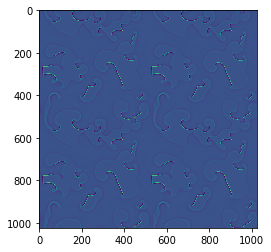

In [4]:
plt.imshow(dpadded_txt_dt)

In [5]:





print(padded_txt.shape)
print(dtexture_dt.shape)

(1024, 1024)
(512, 512, 3)


In [6]:
sigma = .1
threshold = 0.95

In [7]:
#compute contours. type 1 = contours_raw, type 2 = contours_inc
img_nxt = padded_txt.copy()
img_inc = ifilter(dpadded_txt_dt)  #mask of instantaneously increasing voltages 
img_inc = filters.gaussian(img_inc,sigma=sigma, mode='wrap')

contours_raw = measure.find_contours(img_nxt, level=0.5,fully_connected='low',positive_orientation='low')
contours_inc = measure.find_contours(img_inc, level=threshold)#,fully_connected='low',positive_orientation='low')
tips = get_tips(contours_raw, contours_inc)
beep(2)

In [39]:
# tips
0.03*18/5

0.10800000000000001

sigma = 0.1 and threshold = 0.95.


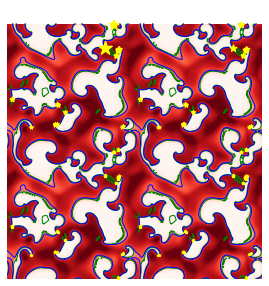

0

In [11]:
n_lst, x_lst, y_lst = get_tips(contours_raw, contours_inc)
tip_states = {'n': n_lst, 'x': x_lst, 'y': y_lst}
print(f"sigma = {sigma} and threshold = {threshold}.")
fig = plot_buffer(img_nxt, img_inc, contours_raw, contours_inc, tips, 
                  figsize=(5,5),max_marker_size=200, lw=1);
plt.grid('on')
plt.show()
beep(2)

In [57]:
# import pandas as pd

@njit
def my_unpad(X, pad, width):
    P  = pad/2
    X -= pad
    if X < -pad/2:
        X = -9999 # throw out X later
    elif X < 0:
        X += width
    if X > width+pad/2:
        X = -9999 # throw out X later
    elif X >= width:
        X -= width
    return X

190

In [58]:
#padded spiral tips are produced with at pixel percision of about 13 digits.
# note that this is not the same as accuracy, which will depend on sigma, threshold, and V_threshold

    
# test functions for my_unpad
# my_unpad(200, 10, 512)

# assert(my_unpad(200, 10, 512)==190)
# assert(
my_unpad(0, 10, 512)
#        ==190)

-9999

In [8]:
def map_pbc_tips_back(tips, pad, width = 512, height = 512):
    s_tips, x_tips, y_tips = tips
    s1_mapped_lst = []; s2_mapped_lst = [];
    x_mapped_lst = []; y_mapped_lst = []; 
    for n, x in enumerate(x_tips):
    # x = x_tips[0]; y = y_tips[0]; s = s_tips[0]
        S1, S2 = s_tips[n]
        y = y_tips[n]
#         x2 = [qx - pad for qx in x]
#         y2 = [qy - pad for qy in y]
        X_lst = []; Y_lst = []; S1_lst = []; S2_lst = []
        for X, Y in zip(x, y):
            X = my_unpad(X, pad, width )
            Y = my_unpad(Y, pad, height)
            S1_lst.append(S1)
            S2_lst.append(S1)
            X_lst.append(X)
            Y_lst.append(Y)
            
            #TODOTODO
            #Define XY lst
            #TAKE THE DIFFERENCES OF XY with all members of XY_lst
            #IF no difference is found less than tol, then add XY to lst and add S = (S1,S2) to lst
            #ELSE extend the tuple list element, S_lst[n] by S where n is the index of the nearly matching tip
        s1_mapped_lst.extend(S1_lst)
        s2_mapped_lst.extend(S2_lst)
        x_mapped_lst.extend(X_lst)
        y_mapped_lst.extend(Y_lst)
    tips_mapped = (list(zip(s1_mapped_lst, s2_mapped_lst)), x_mapped_lst, y_mapped_lst)
    #TODO: drop duplicates
    #TODO: make knots match maybe?
    return tips_mapped
#         s_mapped_lst.append(S_lst)
#         x_mapped_lst.append(X_lst)
#         y_mapped_lst.append(Y_lst)

In [8]:
len(tips_mapped[2])
def drop duplicates(tips_mapped):
    '''TODO: improve this sans pandas'''
    series = pd.Series(x_mapped_lst)
    tol = 1.e-12 #greater than to 5.e-14
error_array = np.diff(np.sort(series[series.duplicated()]))

SyntaxError: invalid syntax (<ipython-input-8-dd6842f469ec>, line 2)

In [9]:
tips_mapped = map_pbc_tips_back(tips, pad = pad)

In [12]:
s_mapped_lst, x_mapped_lst, y_mapped_lst = tips_mapped

In [19]:
s_lst = []; xy_lst = []
for n, x in enumerate(x_mapped_lst):
    y = y_mapped_lst[n]
    xy = (x,y)
    s  = s_mapped_lst[n]
    used = False
    mxxy = len(xy_lst)
    if mxxy==0:
        xy_lst.append(xy)
    while mxxy<=0:
    for m, xy_old in enumerate(xy_lst):
        if 
    if not xy in xy_lst: # TODO: make this more exact
        xy_lst.append(xy)
        s_lst.append(s)
    else:
        #find xy in xy_lst and append s there

In [25]:
x_lst, y_lst = np.array(xy_lst).T.shape


(2, 121)

In [33]:
# np.argwhere(xy_lst,xy)
xy

(668.5683541658234, -155.95)

In [ ]:
# {'x':tips_mapped[1], 'y': tips_mapped[2]}
# tips_mapped[1:]#'s':list(tips_mapped[0])
print(tips_mapped[2])
# df = pd.DataFrame(tips_mapped[1:])#, columns=['s','x','y'])

In [254]:
series = pd.Series(x_mapped_lst)
tol = 1.e-12 #greater than to 5.e-14
error_array = np.diff(np.sort(series[series.duplicated()]))
print(error_array[error_array<tol])

[0.00000000e+00 0.00000000e+00 5.68434189e-14 3.41060513e-13
 0.00000000e+00 0.00000000e+00 5.68434189e-14 5.68434189e-14
 1.13686838e-13 5.68434189e-14 5.68434189e-14 0.00000000e+00]


In [255]:
series = pd.Series(y_mapped_lst)
tol = 1.e-12 #greater than to 5.e-14
error_array = np.diff(np.sort(series[series.duplicated()]))
print(error_array[error_array<tol])

[0.00000000e+00 0.00000000e+00 5.68434189e-14 5.68434189e-14
 0.00000000e+00 0.00000000e+00]


In [195]:
#now remove duplicates
xy_zipped = [xy for xy in zip(x_mapped_lst, y_mapped_lst)]

In [214]:
# xy_df.drop_duplicates(subset=['x','y'])
len(s_mapped_lst)

60

In [217]:
len(x_mapped_lst)

60

In [227]:
s_tips[0]

(0, 0)

In [262]:
len(tips_mapped[0])

60

# Optimize the marching squares algorithm with numba with this!


In [65]:
# import inspect, skimage.measure as measure
# ss = inspect.getsource(
measure.find_contours_
# )
# [print(l) for l in ss.splitlines()]

def find_contours(array, level,
                  fully_connected='low', positive_orientation='low'):
    """Find iso-valued contours in a 2D array for a given level value.

    Uses the "marching squares" method to compute a the iso-valued contours of
    the input 2D array for a particular level value. Array values are linearly
    interpolated to provide better precision for the output contours.

    Parameters
    ----------
    array : 2D ndarray of double
        Input data in which to find contours.
    level : float
        Value along which to find contours in the array.
    fully_connected : str, {'low', 'high'}
         Indicates whether array elements below the given level value are to be
         considered fully-connected (and hence elements above the value will
         only be face connected), or vice-versa. (See notes below for details.)
    positive_orientation : either 'low' or 'high'
         Indicates whether the output contours will produce positively-oriented
   

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]